<a href="https://colab.research.google.com/github/skabra5/Streaming-tweets-with-Tweepy-Visualing-tweets-using-Plotly-real-time-topic-tracking-with-Dash/blob/master/StreamingTweetsTweepy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks/TwitterDash")

In [0]:
!pip install unidecode

In [0]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor

from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import tweepy
import json
import pandas as pd
import csv
import re
from textblob import TextBlob
import string
# import preprocessor as p
import os
import time
import datetime
import sqlite3
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# Twitter credentials
# Obtain them from your twitter developer account
ACCESS_TOKEN = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
ACCESS_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
CONSUMER_KEY = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
CONSUMER_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'


# Streaming Tweets and storing them in "sentiment" table in "twitter.db" using Sqlite3 library

## Creating "twitter.db" using sqlite3

In [0]:
# Creating "sentiment" table with columns unix REAL,  tweet TEXT, tweet_id REAL, 
# favorite_count REAL, retweet_count REAL, follower_count REAL, location TEXT, polarity REAL, sentiment REAL

import sqlite3

conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/TwitterDash/twitter.db')
c = conn.cursor()

# def create_table():
#     c.execute("CREATE TABLE IF NOT EXISTS sentiment(unix REAL, tweet TEXT, sentiment REAL)")
#     conn.commit()

# create_table()

def create_table():
    try:
        c.execute("CREATE TABLE IF NOT EXISTS sentiment(unix REAL,  tweet TEXT, tweet_id REAL, \
        favorite_count REAL, retweet_count REAL, follower_count REAL, location TEXT, polarity REAL, sentiment REAL)")
        c.execute("CREATE INDEX fast_unix ON sentiment(unix)")
        c.execute("CREATE INDEX fast_tweetId ON sentiment(tweet_id)")
        c.execute("CREATE INDEX fast_tweet ON sentiment(tweet)")
        #c.execute("CREATE INDEX fast_hashtags ON sentiment(hashtags)")
        c.execute("CREATE INDEX fast_favorite_count ON sentiment(favorite_count)")
        c.execute("CREATE INDEX fast_retweet_count ON sentiment(retweet_count)")
        c.execute("CREATE INDEX fast_follower_count ON sentiment(follower_count)")
        c.execute("CREATE INDEX fast_location ON sentiment(location)")
        c.execute("CREATE INDEX fast_polarity ON sentiment(polarity)")
        c.execute("CREATE INDEX fast_sentiment ON sentiment(sentiment)")
        conn.commit()
    except Exception as e:
        print(str(e))
create_table()

In [0]:
# Defining a function to return sentiment based on Textblob's polarity attribute

def analyze_sentiment(tweet):
  analysis = TextBlob(tweet)
  polarity = analysis.polarity
  subjectivity = analysis.subjectivity
  
  if analysis.sentiment.polarity > 0:
    return 1
  elif analysis.sentiment.polarity == 0:
    return 0
  else:
    return -1

In [0]:
# Streaming tweets with the required column; filtering language as "en";
# track=["a","e","i","o","u"] streams all the tweets, track could be used to specify a topic to stream tweets on

class listener(StreamListener):

    def on_data(self, data):
        try:
            data = json.loads(data)
            tweet = unidecode(data['text'])
            tweet_id = data["id_str"]

            #hashtags = data["entities"]["hashtags"]
            favorite_count = data["favorite_count"]
            retweet_count = data["retweet_count"]
            follower_count = data["user"]["followers_count"]
            location = data['user']['location']
            time_ms = data['timestamp_ms']
            analysis = TextBlob(tweet)
            polarity = analysis.sentiment.polarity
            sentiment = analyze_sentiment(tweet)
            print(time_ms, tweet, sentiment)
            c.execute("INSERT INTO sentiment (unix, tweet,tweet_id,favorite_count, retweet_count, follower_count, location,polarity, sentiment) VALUES (?,?,?,?,?, ?,?, ?,?)",
                  (time_ms, tweet,tweet_id,favorite_count, retweet_count, follower_count,location, polarity,sentiment))
            conn.commit()

        except KeyError as e:
            print(str(e))
        return(True)

    def on_error(self, status):
        print(status)

while True:

    try:
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
        twitterStream = Stream(auth, listener(),wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
        twitterStream.filter(track=["a","e","i","o","u"], languages=["en"])
    except Exception as e:
        print(str(e))
        time.sleep(5)

In [0]:
# Checking the contents of sentiment table from twitter.db

cur = conn.cursor()
cur.execute("SELECT * FROM sentiment")

rows = cur.fetchall()

for row in rows:
  print(row)

In [0]:
def select_all_tasks(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM sentiment")

    rows = cur.fetchall()

    for row in rows:
        print(row)

In [0]:
conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/FinalTwitterDashTesla/twitter.db')
c = conn.cursor()
tweets_df = pd.read_sql_query("SELECT * from sentiment", conn)
tweets_df.sort_values('unix', inplace=True)
# tweets_df['sentiment_smoothed'] = tweets_df['polarity'].rolling(int(len(tweets_df)/5)).mean()

# Convert UTC into PDT
tweets_df['DateTime'] = pd.to_datetime(tweets_df['unix'], unit='ms')
tweets_df = tweets_df.drop(columns="unix")

tweets_df['sentiment'] = tweets_df['sentiment'].apply(np.int64)

tweets_df.head(5)

In [0]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20436 entries, 18 to 20426
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet           20436 non-null  object        
 1   tweet_id        20436 non-null  float64       
 2   favorite_count  20436 non-null  float64       
 3   retweet_count   20436 non-null  float64       
 4   follower_count  20436 non-null  float64       
 5   location        20436 non-null  object        
 6   polarity        20436 non-null  float64       
 7   sentiment       20436 non-null  int64         
 8   DateTime        20436 non-null  datetime64[ns]
 9   CleanTweet      20436 non-null  object        
 10  Sentiment_id    20436 non-null  int64         
 11  Hashtags        20436 non-null  object        
 12  Handles         20436 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 2.2+ MB


# Visualization 1: Sentiment and number of tweets fluctuation over time on the topic of race

In [0]:
race_df = tweets_df[tweets_df['tweet'].str.contains("racism|racist|black|lives|matter|usa")]

In [0]:
race_df.shape

(1114, 13)

In [0]:
# Clean and transform data to enable time series
result = race_df.groupby(                                        \
      [pd.Grouper(key='DateTime', freq='10s'), 'sentiment'] \
    ).count().unstack(fill_value=0).stack().reset_index()

result = result.rename(columns=                             \
    { "tweet_id": "Num of '{}' mentions".format("racial"),  \
      "DateTime":"Time in UTC" })

In [0]:
time_series = result["Time in UTC"][result['sentiment']==0].reset_index(drop=True)

In [0]:
import plotly.express as px
fig = px.line(result, x='Time in UTC',                      \
    y="Num of '{}' mentions".format("racial"),            \
    color='sentiment')
fig.show()

# Visualization 2: Studying the frequency distribution of words and hashtags in tweets


In [0]:
# Cleaning the tweets using RegEx library: Removing weblinks & "RT"; Keeping Alphanumeric content only and converting into lowercase
def cleanFunc(content):
  # content = ' '.join(tweets_df["tweet"])
  content = re.sub(r"http\S+", "", content)
  content = content.replace('RT ', ' ').replace('&amp;', 'and')
  content = re.sub('[^A-Za-z0-9]+', ' ', content)
  content = content.lower()

  return content

In [0]:
%time tweets_df['CleanTweet'] = tweets_df['tweet'].apply(lambda x: cleanFunc(x))

CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 169 ms


In [0]:
tweets_df.head()

,tweet,tweet_id,favorite_count,retweet_count,follower_count,location,polarity,sentiment,DateTime,CleanTweet
18,You're body is so sexy that I feel it in the m...,1.270523e+18,0.0,0.0,86.0,None,0.400,1.0,2020-06-10 01:07:22.742,you re body is so sexy that i feel it in the m...
4,@Laethageal @jeroneanderson @SusanKowal7 @roxy...,1.270523e+18,0.0,0.0,176.0,"Pacific NW, USA",0.000,0.0,2020-06-10 01:07:22.829,laethageal jeroneanderson susankowal7 roxylov...
7,Let's end the day with a bang. A good night t...,1.270523e+18,0.0,0.0,4260.0,"Washington, D.C.",0.350,1.0,2020-06-10 01:07:22.831,let s end the day with a bang a good night to ...
2,Good Question!,1.270523e+18,0.0,0.0,793.0,None,0.875,1.0,2020-06-10 01:07:22.833,good question
0,"We love a woke SK. Padayon, SK-Cebu City! #Iba...",1.270523e+18,0.0,0.0,419.0,"Davao, Philippines",0.625,1.0,2020-06-10 01:07:22.843,we love a woke sk padayon sk cebu city ibasura...


## Word Cloud of all tweets, and tweets with negative and positive sentiment

CPU times: user 2.72 s, sys: 50.5 ms, total: 2.77 s
Wall time: 2.77 s


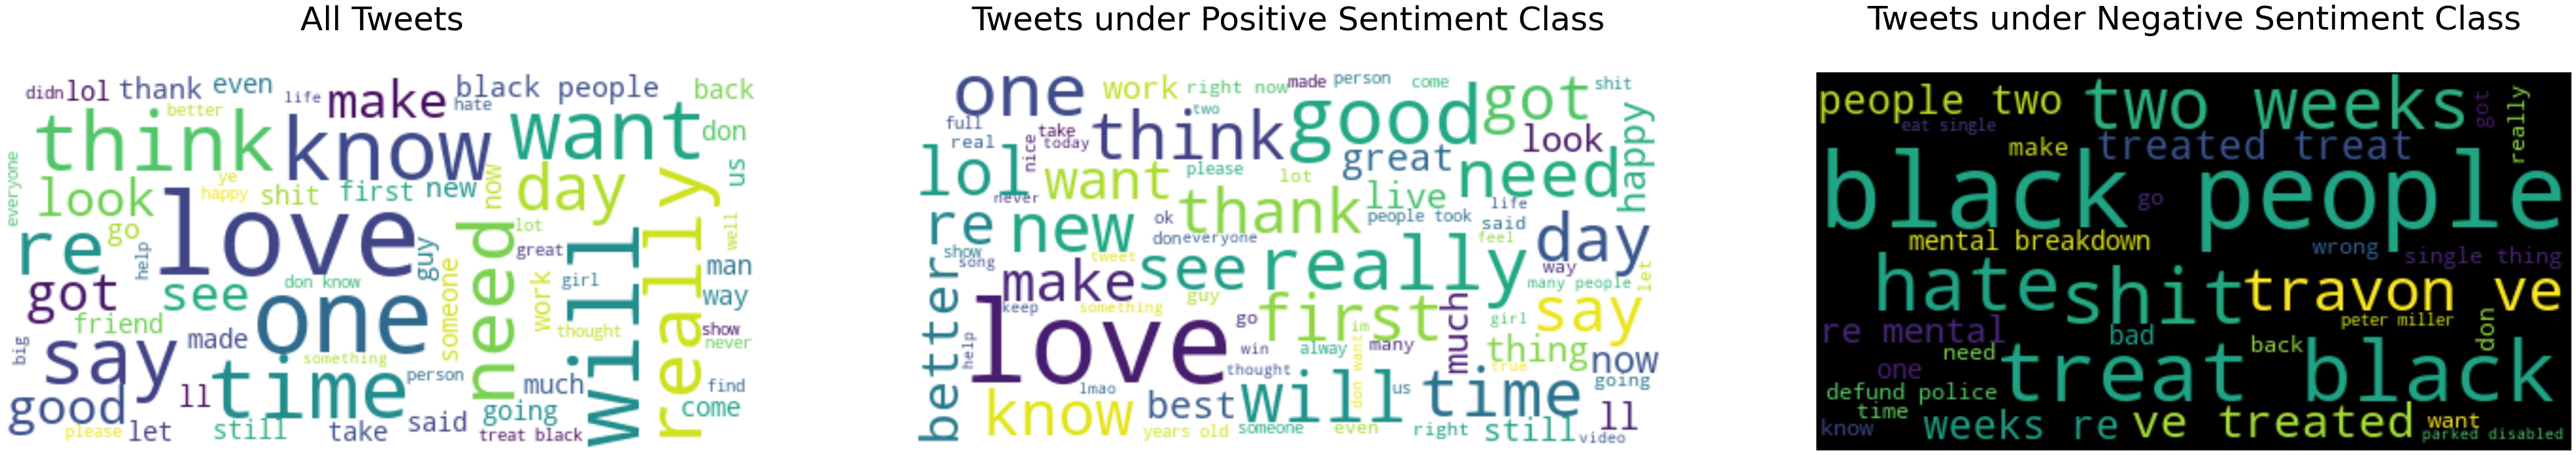

In [0]:
%%time 
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
# Start with one review:
df_pos = tweets_df[tweets_df['sentiment']==1.0]
df_neg = tweets_df[tweets_df['sentiment']==-1.0]
tweet_All = " ".join(review for review in tweets_df.CleanTweet)
tweet_pos = " ".join(review for review in df_pos.CleanTweet)
tweet_neg = " ".join(review for review in df_neg.CleanTweet)

fig, ax = plt.subplots(1, 3, figsize  = (70,70))


# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=60, min_font_size=8, max_words=100, background_color="white").generate(tweet_All)
wordcloud_pos = WordCloud(max_font_size=60, min_font_size=8, max_words=100, background_color="white").generate(tweet_pos)
wordcloud_neg = WordCloud(max_font_size=60, min_font_size=8, max_words=100, background_color="black").generate(tweet_neg)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets\n', fontsize=50)
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].set_title('Tweets under Positive Sentiment Class\n',fontsize=50)
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation='bilinear')
ax[2].set_title('Tweets under Negative Sentiment Class\n',fontsize=50)
ax[2].axis('off')



## Frequency distribution of words in tweets

In [0]:
# Removing punctuation, stopwords
# Getting frequency distribution of words

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

content = ' '.join(tweets_df["CleanTweet"])
tokenized_word = word_tokenize(content)
stop_words=set(stopwords.words("english"))
filtered_sent=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
fdist = FreqDist(filtered_sent)
fd = pd.DataFrame(fdist.most_common(20),                    \
    columns = ["Word","Frequency"]).drop([0]).reindex()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
fd.head()

,Word,Frequency
1,people,1247
2,u,927
3,one,914
4,black,857
5,know,822


In [0]:
import plotly.express as px
fig = px.bar(fd, x="Word", y="Frequency",
             color = "Frequency", height = 400,  color_continuous_scale = "Inferno", width = 1000)
# fig.update_traces(marker_color='rgb(240,128,128)',          \
#     marker_line_color='rgb(8,48,107)',                      \
#     marker_line_width=1.5, opacity=0.8)
fig.show()

## Most Frequent Unigrames and Bigrams using TFIDF features and Chi Square test

In [0]:
#TfidfVectorizer for text classification

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Transform the training data: tfidf_train 
tfidf_tweets = tfidf_vectorizer.fit_transform(tweets_df["CleanTweet"])

# Transform the test data: tfidf_test 
# tfidf_test = tfidf_vectorizer.transform(tweets_df["CleanTweet"])

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
#print(tfidf_train.A[:10])

['00', '00 pm', '000', '000 000', '000 active', '000 fucking', '000 like', '000 likes', '000 people', '00pm']


In [0]:
getFeatures_df = tweets_df
getFeatures_df['Sentiment_id'] = getFeatures_df['sentiment'].factorize()[0]
sentiment_id_df = getFeatures_df[['sentiment', 'Sentiment_id']].drop_duplicates().sort_values('Sentiment_id')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['Sentiment_id', 'sentiment']].values)
labels = getFeatures_df.Sentiment_id
getFeatures_df.head()


,tweet,tweet_id,favorite_count,retweet_count,follower_count,location,polarity,sentiment,DateTime,CleanTweet,Sentiment_id
18,You're body is so sexy that I feel it in the m...,1.270523e+18,0.0,0.0,86.0,None,0.400,1.0,2020-06-10 01:07:22.742,you re body is so sexy that i feel it in the m...,0
4,@Laethageal @jeroneanderson @SusanKowal7 @roxy...,1.270523e+18,0.0,0.0,176.0,"Pacific NW, USA",0.000,0.0,2020-06-10 01:07:22.829,laethageal jeroneanderson susankowal7 roxylov...,1
7,Let's end the day with a bang. A good night t...,1.270523e+18,0.0,0.0,4260.0,"Washington, D.C.",0.350,1.0,2020-06-10 01:07:22.831,let s end the day with a bang a good night to ...,0
2,Good Question!,1.270523e+18,0.0,0.0,793.0,None,0.875,1.0,2020-06-10 01:07:22.833,good question,0
0,"We love a woke SK. Padayon, SK-Cebu City! #Iba...",1.270523e+18,0.0,0.0,419.0,"Davao, Philippines",0.625,1.0,2020-06-10 01:07:22.843,we love a woke sk padayon sk cebu city ibasura...,0


In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
#for Sentiment, Sentiment_id in sorted(sentiment_to_id.items()):
features_chi2 = chi2(tfidf_tweets, labels)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#print("# '{}':".format(Sentiment))
print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
print("Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

Most correlated unigrams:
. fuck
. black
. love
Most correlated bigrams:
. travon ve
. treat black
. black people


## Frequency distribution of Hashtags

In [0]:
from nltk.tokenize import regexp_tokenize

def extract_hashtags(text):
  pattern1 = r"#\w+"
  hashtags = regexp_tokenize(text, pattern1)
  if len(hashtags) ==0:
    hashtags = ""
  
  return hashtags

def extract_handles(text):
  pattern2 = r"@\w+"
  handles = regexp_tokenize(text, pattern2)
  if len(handles) ==0:
    handles = ""
  
  return handles

tweets_df["Hashtags"] = tweets_df["tweet"].apply(lambda x: extract_hashtags(x))
tweets_df["Handles"] = tweets_df["tweet"].apply(lambda x: extract_handles(x))
tweets_df.head(20)


,tweet,tweet_id,favorite_count,retweet_count,follower_count,location,polarity,sentiment,DateTime,CleanTweet,Sentiment_id,Hashtags,Handles
18,You're body is so sexy that I feel it in the m...,1.270523e+18,0.0,0.0,86.0,None,0.400000,1.0,2020-06-10 01:07:22.742,you re body is so sexy that i feel it in the m...,0,,
4,@Laethageal @jeroneanderson @SusanKowal7 @roxy...,1.270523e+18,0.0,0.0,176.0,"Pacific NW, USA",0.000000,0.0,2020-06-10 01:07:22.829,laethageal jeroneanderson susankowal7 roxylov...,1,,"[@Laethageal, @jeroneanderson, @SusanKowal7, @..."
7,Let's end the day with a bang. A good night t...,1.270523e+18,0.0,0.0,4260.0,"Washington, D.C.",0.350000,1.0,2020-06-10 01:07:22.831,let s end the day with a bang a good night to ...,0,,
2,Good Question!,1.270523e+18,0.0,0.0,793.0,None,0.875000,1.0,2020-06-10 01:07:22.833,good question,0,,
0,"We love a woke SK. Padayon, SK-Cebu City! #Iba...",1.270523e+18,0.0,0.0,419.0,"Davao, Philippines",0.625000,1.0,2020-06-10 01:07:22.843,we love a woke sk padayon sk cebu city ibasura...,0,[#IbasuraAngTerrorBill],
3,@FelicityDisco I'm definitely curious!,1.270523e+18,0.0,0.0,1261.0,"Arkansas, USA",-0.125000,-1.0,2020-06-10 01:07:22.846,felicitydisco i m definitely curious,2,,[@FelicityDisco]
8,Can you believe this is in an America city???!...,1.270523e+18,0.0,0.0,135.0,United States,0.000000,0.0,2020-06-10 01:07:22.846,can you believe this is in an america city omg...,1,,
6,"RT @MrAndyNgo: Abolish police, get Antifa: Mil...",1.270523e+18,0.0,0.0,584.0,"Tehran , Istanbul , Yerevan",0.000000,0.0,2020-06-10 01:07:22.847,mrandyngo abolish police get antifa militants...,1,,[@MrAndyNgo]
1,RT @kaydashion: Won't cost a penny for you to ...,1.270523e+18,0.0,0.0,469.0,None,0.000000,0.0,2020-06-10 01:07:22.853,kaydashion won t cost a penny for you to retw...,1,,[@kaydashion]
14,Congratulations,1.270523e+18,0.0,0.0,34.0,United States,0.000000,0.0,2020-06-10 01:07:22.853,congratulations,1,,


In [0]:
%time tweets_df['Hashtags'] = tweets_df.Hashtags.apply(lambda x: ','.join([str(i) for i in x]))
%time all_hashtags = " ".join(hasht for hasht in tweets_df.Hashtags)
hash_list = list(all_hashtags.split(" ")) 

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 16.9 ms
CPU times: user 3.66 ms, sys: 0 ns, total: 3.66 ms
Wall time: 3.67 ms


In [0]:
hash_fdist = FreqDist(hash_list)
hash_fd = pd.DataFrame(hash_fdist.most_common(20),                    \
    columns = ["Hashtag","Frequency"]).drop([0]).reindex()

In [0]:
hash_fd

,Hashtag,Frequency
1,#KCON,52
2,#BlackLivesMatter,38
3,#BLACKPINKISCOMING,28
4,#VogueChallenge,24
5,#GeorgeFloyd,17
6,#HappyBirthdayNBK,14
7,#BLM,12
8,#BoycottSainsburys,9
9,"#yuyuhakusho,#instantwin,#sweepstakes",8
10,#1,8


In [0]:
import plotly.express as px
hash_fig = px.bar(hash_fd, x="Hashtag", y="Frequency",
             color = "Frequency", height = 400,  color_continuous_scale = "Inferno", width = 1000)
# fig.update_traces(marker_color='rgb(240,128,128)',          \
#     marker_line_color='rgb(8,48,107)',                      \
#     marker_line_width=1.5, opacity=0.8)
hash_fig.show()

# Visualization 3: Geographiv distribusion of tweets

In [0]:
import itertools  

STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR','California', 'CA' ,'Colorado','CO',"Connecticut" , "CT","Delaware", "DE","Florida", "FL","Georgia","GA","Hawaii", "HI", 'Idaho','ID', 'Illinois', "IL",
         "Indiana" ,'IN', 'Iowa' ,'IA','Kansas','KS','Kentucky', 'KY',"Louisiana", "LA","Maine", 'ME','Maryland','MD','Massachusetts' ,'MA',\
         'Michigan','MI','Minnesota' ,'MN','Mississippi' , 'MS', 'Missouri','MO','Montana' ,'MT','Nebraska', 'NE','Nevada' ,'NV',\
         'New Hampshire','NH','New Jersey','NJ','New Mexico','NM','New York', 'NY','North Carolina', 'NC','North Dakota' ,'ND','Ohio', 'OH', \
         'Oklahoma','OK','Oregon','OR','Pennsylvania' , 'PA','Rhode Island', 'RI','South Carolina' , 'SC','South Dakota' ,'SD',\
         'Tennessee' , 'TN','Texas', 'TX','Utah' , 'UT','Vermont' , 'VT','Virginia' ,'VA','Washington' ,'WA','West Virginia','WV', \
         'Wisconsin', 'WI', 'Wyoming', 'WY']
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [0]:
is_in_US=[]
geo = tweets_df[['location']]
tweets_df = tweets_df.fillna(" ")
for x in tweets_df['location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(None)

geo_dist = pd.DataFrame(is_in_US, columns = ['State'])           \
    .dropna().reset_index()

In [0]:
geo_dist

,index,State
0,2,WA
1,5,AR
2,10,AR
3,29,OR
4,30,NY
...,...,...
5240,20420,PA
5241,20424,TX
5242,20425,PA
5243,20429,PA


In [0]:
import math
geo_dist = geo_dist.groupby('State').count().\
    rename(columns={"index": "Number"}).sort_values(\
    by=['Number'], ascending=False).reset_index()
geo_dist["Log Num"] = geo_dist["Number"] \
    .apply(lambda x: math.log(x, 2))

geo_dist['Full State Name'] = geo_dist['State']               \
    .apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' +     \
    'Num: ' + geo_dist['Number'].astype(str)

In [0]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Log Num'].astype(float), # Data to be color-coded

    locationmode = 'USA-states', 
    colorscale = "Reds",
    text=geo_dist['text'],
    marker_line_color='white', # line markers between states
    colorbar_title = "Numbers in Log2"
))

fig.update_layout(
    geo_scope='usa', 
)

fig.show()

# Creating subplots: Combining all the plots

In [0]:
from plotly.subplots import make_subplots
fig = make_subplots(
        rows=7, cols=3,
        column_widths=[2, 0.8, 0.6],
        row_heights=[0.6, 0.4, 0.8,0.4, 0.8, 0.5, 1],
        specs=[[{"type": "scatter", "rowspan": 2},  {"type": "choropleth", "rowspan": 3, "colspan":2}, None],
                [ None,None,None],
               [ None,None,None],
               [ None,None,None],
               [{"type": "bar", "rowspan": 2},{"type": "bar", "rowspan": 2, "colspan":2}, None],
               
        [ {"type": "bar", "rowspan": 2},{"type": "bar"}, None],
        [ None,None, None]]
         )

In [0]:
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of '{}' mentions"                     \
        .format("racial")]               \
        [result['sentiment']==0].reset_index(drop=True), \
    name="Neutral",
    opacity=0.8), row=1, col=1)   
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of '{}' mentions" \
        .format("racial")][result['sentiment']==-1].reset_index(drop=True),
    name="Negative",
    opacity=0.8), row=1, col=1)
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of '{}' mentions"                     \
        .format("racial")]               \
        [result['sentiment']==1].reset_index(drop=True), \
    name="Positive",
    opacity=0.8), row=1, col=1)

fig.add_trace(go.Bar(x=fd["Word"], y=fd["Frequency"],       \
    name="Words Freq Dist"), row=5, col=1)

fig.update_traces(marker_color='orangered',          \
    marker_line_color='rgb(8,48,107)',                      \
    marker_line_width=0.5, opacity=0.7, row=5, col=1)

fig.add_trace(go.Bar(x=hash_fd["Hashtag"], y=hash_fd["Frequency"],       \
    name="Haghtag Freq Dist"), row=5, col=2)

fig.update_traces(marker_color='orange',          \
    marker_line_color='rgb(8,48,107)',                      \
    marker_line_width=0.5, opacity=0.7, row=5, col=2)

fig.add_trace(go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Log Num'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', 
    colorscale = "Blues",
    text=geo_dist['text'], # hover text
    showscale=False,
    geo = 'geo'
    ), row=1, col=2)

fig.update_layout(
    title_text =                                            \
      "Real-time tracking '{}' mentions on Twitter {} UTC"  \
      .format("racism"       
        ,datetime.datetime.utcnow().strftime('%m-%d %H:%M') \
      ),
    geo = dict(
        scope='usa',
    ),
    template="plotly_dark",
    margin=dict(r=20, t=50, b=50, l=20),
    annotations=[
        go.layout.Annotation(
            text="Source: Twitter",
            showarrow=False, xref="paper", yref="paper",
            x=0,
            y=0)
    ],
    showlegend=False,
    xaxis_rangeslider_visible=True)